In [1]:
import pandas as pd
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [3]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.

In [4]:
from mvpa2 import *

In [5]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [6]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
results_filepath=ml_data_folderpath + "/SST/mvpa_tt_res_v3_conditions_84subs_twoclasses_pfcmask.pkl"

In [7]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [8]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [9]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [10]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [11]:
for kn in individual_differences.keys():
    print(kn +", " + str(type(individual_differences[kn])))
    print(individual_differences[kn].tolist())


subject, <class 'pandas.core.series.Series'>
['DEV001', 'DEV002', 'DEV004', 'DEV005', 'DEV006', 'DEV007', 'DEV008', 'DEV009', 'DEV010', 'DEV011', 'DEV012', 'DEV013', 'DEV014', 'DEV015', 'DEV016', 'DEV017', 'DEV018', 'DEV019', 'DEV020', 'DEV021', 'DEV022', 'DEV023', 'DEV024', 'DEV025', 'DEV026', 'DEV027', 'DEV028', 'DEV029', 'DEV030', 'DEV031', 'DEV032', 'DEV033', 'DEV034', 'DEV035', 'DEV036', 'DEV037', 'DEV038', 'DEV039', 'DEV040', 'DEV041', 'DEV042', 'DEV043', 'DEV044', 'DEV045', 'DEV046', 'DEV047', 'DEV048', 'DEV049', 'DEV050', 'DEV051', 'DEV052', 'DEV053', 'DEV054', 'DEV055', 'DEV056', 'DEV057', 'DEV058', 'DEV059', 'DEV060', 'DEV061', 'DEV062', 'DEV063', 'DEV064', 'DEV065', 'DEV066', 'DEV067', 'DEV068', 'DEV069', 'DEV070', 'DEV071', 'DEV072', 'DEV073', 'DEV074', 'DEV075', 'DEV076', 'DEV077', 'DEV078', 'DEV079', 'DEV080', 'DEV081', 'DEV082', 'DEV083', 'DEV084', 'DEV085', 'DEV086', 'DEV087', 'DEV088', 'DEV089', 'DEV090', 'DEV091', 'DEV093', 'DEV094', 'DEV095', 'DEV096', 'DEV097', 'DEV

In [12]:
import sys

sys.path.append(os.path.abspath("../../ml/"))

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [13]:
spm_file = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat'
sl_mat = scipy.io.loadmat(
    spm_file,
    simplify_cells=True            
)

#convert from an SPM.mat file into a dataframe list of the betas
beta_dict_list = []
mat_betas = sl_mat['SPM']['Vbeta']
for beta_i in range(len(mat_betas)):
    beta = mat_betas[beta_i]
    b_description = beta['descrip']
    condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)
    if (condition_label is not None):
        beta_dict_list = beta_dict_list + [{
            'condition_index':beta_i,
            'condition_label':condition_label.group(1),
            'raw_beta_description':beta['descrip'],
            'beta':beta['fname']
        }]
#    print(condition_label)
beta_df = pd.DataFrame(beta_dict_list)

#fill in the details related to the subject
beta_df['subject']='DEV005'
beta_df['wave']=1

<>:13: DeprecationWarning: invalid escape sequence \(
<>:13: DeprecationWarning: invalid escape sequence \(
/tmp/ipykernel_8811/122697270.py:13: DeprecationWarning: invalid escape sequence \(
  condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)


In [16]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

In [17]:
import mvpa2.datasets 

In [18]:
import nibabel as nib

In [17]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_2_',
    concatenate_condition_labels=False,
    mask="beta"
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii
 * Please note: warnings are printed only once, but underlying problem might occur many times *
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/beta_0001.nii
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject

In [17]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_2_',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii
 * Please note: warnings are printed only once, but underlying problem might occur many times *
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/beta_0001.nii
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject

In [34]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:2],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond_',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_2subs_correct_cond_.pkl


In [32]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected[0:10],'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject DEV009. Skipping this subject.
DEV010
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV010/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV014
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV014/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV016/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_10subs_correct_cond.pkl


In [33]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected,'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond',
    concatenate_condition_labels=False
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV009
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV009/SPM.mat
not enough conditions for subject DEV009. Skipping this subject.
DEV010
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV010/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV011
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV011/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV014
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV014/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV016/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV018
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV018/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV019
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV019/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV020
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV020/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV021
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV022
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV022/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV023
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV023/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV024
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV024/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV025
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV025/SPM.mat
not enough conditions for subject DEV025. Skipping this subject.
DEV026
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV026/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV027
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV027/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV028
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV028/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV029
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV029/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV030
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV030/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV034
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV034/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV035
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV035/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV036
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV036/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV039
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV040
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV040/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV041
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV041/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV042
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV042/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV043
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV043/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV046
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV046/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV047
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV047/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV048
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV048/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV049
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV049/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV050
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV050/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV051
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV051/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV052
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV052/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV053
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV055
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV055/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV056
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV056/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV057
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV057/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV058
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV058/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV059
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV059/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV060
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV060/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV062
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV062/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV064
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV064/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV067
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV067/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV068
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV068/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV069
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV069/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV071
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV073
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV073/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV074
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV074/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV076
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV076/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV077
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV077/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV079
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV079/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV083
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV083/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV084
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV084/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV085
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV085/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV086
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV086/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV087
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV087/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV089
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV089/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV097
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV105
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV105/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV107
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV107/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV135
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV135/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV141
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV141/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV145
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV145/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV157
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV157/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV158
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV158/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV159
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV159/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV164
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV164/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV169
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV169/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV171
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV171/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV173
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV177
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV177/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV186
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV186/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV197
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV197/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV206
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV206/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV215
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV215/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV216
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV216/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV217
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV217/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
DEV218
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV218/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


loading files. This step may take some time...
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl


In [102]:
sa_to_df(my_test_data.sa)

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [104]:
my_test_data.shape

(4, 1082035)

In [105]:
sa_to_df(my_test_data.sa)

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [106]:
my_test_data.fa

FeatureAttributesCollection(items=[ArrayCollectable(name='voxel_indices', doc=None, value=array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [ 96, 114,  94],
       [ 96, 114,  95],
       [ 96, 114,  96]]), length=1082035)])

In [110]:
my_test_data.a['get_sa_as_df'] = lambda: sa_to_df(my_test_data.sa)

In [111]:
my_test_data.a.get_sa_as_df()

,time_indices,time_coords,condition_index,condition_label,raw_beta_description,beta,subject,wave,cancer_promoting_minus_preventing_FCI,cancer_promoting_minus_preventing_FFQ,...,WTP_unhealthy,WTP_unhealthy_minus_healthy,SRHI_healthy_minus_unhealthy,RTFS_f1_minus_f2,IPAQ_walkingMETminutes,IPAQ_moderateMETminutes,IPAQ_vigorousMETminutes,IPAQ_total_METminutes,IPAQ_MET_kCal,birthsex_factor
0,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
1,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV005,1,0.083871,0.321154,...,2.451613,0.170363,-38.0,NaN,99.0,160.0,NaN,NaN,NaN,Female
2,0,0.0,0,CorrectGo,spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1),beta_0001.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female
3,1,2.0,1,CorrectStop,spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1),beta_0002.nii,DEV006,1,0.430645,-0.603846,...,1.838710,-0.494624,-16.0,NaN,1039.5,1080.0,NaN,NaN,NaN,Female


In [13]:
from generic_utils import *

In [14]:
mask_list = get_all_masks(ml_data_folderpath)

In [15]:
mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex']

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/harvardoxford-cortical_prob_Frontal Orbital Cortex.nii.gz'

In [16]:
my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected,'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_cond',
    concatenate_condition_labels=False,
    mask=mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex']
)

NameError: name 'import_beta_series_pymvpa2' is not defined

In [17]:
beta_imgpath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii'

In [20]:
import nibabel as nib

In [21]:
mask_img = nib.load(mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex'])
mask_img.shape

(182, 218, 182)

In [22]:
beta_img = nib.load('/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii')
beta_img.shape

(97, 115, 97)

In [23]:
fmri_dataset(beta_imgpath,mask=mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex'])

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


ValueError: FlattenMapper has not been trained for data shape '(182, 218, 182)' (known only '(97, 115, 97)').

In [24]:
import nilearn as nil
from nilearn.image import resample_img

In [60]:
mask_img = nib.load(mask_list['harvardoxford-cortical_prob_Frontal Orbital Cortex'])
beta_img = nib.load('/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii')
print(mask_img.shape)
print(resample_img(mask_img,beta_img.affine).shape)
print(resample_img(mask_img,beta_img.affine,fill_value=0,force_resample=True).shape)
print(resample_img(mask_img,beta_img.affine,target_shape = beta_img.shape).shape)
print(beta_img.shape)

(182, 218, 182)
(94, 113, 95)
(94, 113, 95)
(97, 115, 97)
(97, 115, 97)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [61]:
beta_series_pathlist= ['/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii',
                      '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0002.nii']

In [75]:
mask_img

In [81]:
mask_in_subj_space = resample_img(mask_img,beta_img.affine,target_shape = beta_img.shape)
mask_data = (mask_in_subj_space.get_fdata()>0).astype(float)

In [85]:
mask_in_subj_space = nib.Nifti1Image(mask_data,header=mask_in_subj_space.header,affine=mask_in_subj_space.affine)

In [34]:
from mvpa2.datasets.mri import map2nifti

In [87]:
masked_series = fmri_dataset(beta_series_pathlist,mask=mask_in_subj_space)
masked_series_nifti = map2nifti(masked_series)
nib.save(masked_series_nifti,'/gpfs/projects/sanlab/bsmith16/test_series.nii.gz')

In [27]:
masked_image = fmri_dataset(beta_img,mask_in_subj_space)

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [28]:
from nilearn.plotting import plot_img

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


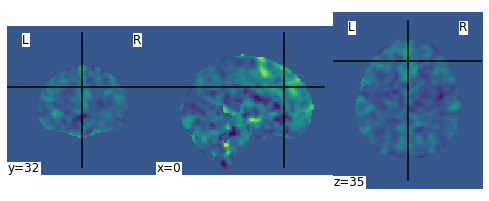

In [31]:
beta_img = nib.load('/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii')
plot_img(beta_img)

In [55]:
mask_img

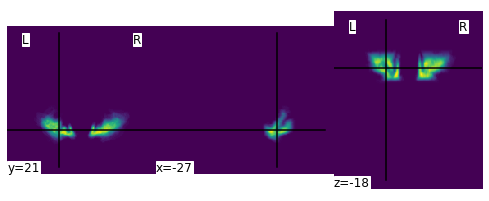

In [32]:
plot_img(mask_img)

In [52]:
beta_img = nib.load('/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii')
nifti_img = squeeze_image(map2nifti(fmri_dataset(beta_img,mask_img)))

In [58]:
nib.save(map2nifti(fmri_dataset(beta_img,mask_in_subj_space)),'/gpfs/projects/sanlab/bsmith16/test_img.nii.gz')

In [54]:
plot_img(nifti_img)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [40]:
fmri_dataset(beta_img)

Dataset(memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), sa=SampleAttributesCollection(items=[ArrayCollectable(name='time_indices', doc='Sequence attribute', value=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]), length=97), ArrayCollectable(name='time_coords', doc='Sequence attribute', value=array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.

In [62]:
print(map2nifti(fmri_dataset(beta_img)).shape)
plot_img(map2nifti(fmri_dataset(beta_img)))

(1, 97, 115, 97)


DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

In [38]:
plot_img(map2nifti(masked_image))

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'